### Импорт необходимых библиотек

In [1]:
#импорт необходимых библиотек
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore') 


### Обработка данных

In [4]:
df = pd.read_csv('C:\\Users\\dmona\\Downloads\\data.txt')
df = df.drop('Unnamed: 18', axis=1)

Приведем цену в формат чисел:

In [5]:
df['Цена'] = pd.to_numeric(df['Цена'])

Обработаем переменные `Багаж`, `Ручная_кладь`, `Возврат`, `Обмен`:

In [6]:
luggage = {}
for p in df['Багаж'].unique():
    info = p.split(' ')
    if info[1].isdigit():
        luggage[p] = int(info[1])
    if '×' in info[1]:
        luggage[p] = int(info[1][-2:])*2    
    else:
        luggage[p] = 0

df['Багаж'] = df['Багаж'].apply(lambda x: luggage[x])

In [7]:
hand_luggage = {}
for p in df['Ручная_кладь'].unique():
    info = p.split(' ')
    if info[2].isdigit():
        hand_luggage[p] = int(info[2])   
    else:
        hand_luggage[p] = 0

df['Ручная_кладь'] = df['Ручная_кладь'].apply(lambda x: hand_luggage[x])

In [8]:
return_tickets = {'Без возврата' : 0, 'Возврат со сбором': 1}
df['Возврат'] = df['Возврат'].apply(lambda x: return_tickets[x])

exchange = {'Без обмена': 0,'Обмен со сбором': 1}
df['Обмен'] = df['Обмен'].apply(lambda x: exchange[x])

Обработаем дату отправления и прибытия, а также дни недели отправления и прибытия.

In [9]:
День_отправления = df['Дата_отправления'].str.split(' ', expand=True)[0]
Месяц_отправления = df['Дата_отправления'].str.split(' ', expand=True)[1]
df.insert(8, 'Месяц_отправления' ,Месяц_отправления)
df.insert(8, 'День_отправления', День_отправления)
months = {'июня': 'Jun', 'июля': 'Jul', 'августа': 'Aug'}
df['Месяц_отправления'] = df['Месяц_отправления'].apply(lambda x: months[x]) # Заменяем русские месяца на английские
df['Дата_отправления'] = df['День_отправления'] + " " + df['Месяц_отправления']
df = df.drop(columns=['Месяц_отправления', 'День_отправления'], axis = 1)
day_of_week = {'пн': 1, 'вт': 2, 'ср': 3, 'чт': 4, 'пт': 5, 'сб': 6, 'вс': 7}
df['День_недели_отправления'] = df['День_недели_отправления'].apply(lambda x: day_of_week[x])


In [10]:
День_прибытия = df['Дата_прибытия'].str.split(' ', expand=True)[0]
Месяц_прибытия = df['Дата_прибытия'].str.split(' ', expand=True)[1]
df.insert(9, 'Месяц_прибытия' ,Месяц_прибытия)
df.insert(9, 'День_прибытия', День_прибытия)
months = {'июня': 'Jun', 'июля': 'Jul', 'августа': 'Aug'}
df['Месяц_прибытия'] = df['Месяц_прибытия'].apply(lambda x: months[x])
df['Дата_прибытия'] = df['День_прибытия'] + " " + df['Месяц_прибытия']
df = df.drop(columns=['Месяц_прибытия', 'День_прибытия'], axis = 1)
df['День_недели_прибытия'] = df['День_недели_прибытия'].apply(lambda x: day_of_week[x])

Напишем функцию, которая переводит время в полете из текста в число - количество минут в полете:

In [11]:
def time_in_air_to_minutes(time_str: str):
    words = time_str.split(' ')
    if 'ч' in words:
        hours = words[0]
        minutes = words[2]
        if minutes.isdigit():
            return int(hours) * 60 + int(minutes)
        else:
            return int(hours) * 60
    else:
        minutes = words[0]
        return int(minutes)

In [12]:
df['Время_в_пути'] = df['Время_в_пути'].apply(time_in_air_to_minutes)

In [13]:
df['Время_отправления'] = df['Время_отправления'] + " " + df['Дата_отправления']

In [14]:
df['Время_прибытия'] = df['Время_прибытия'] + " " + df['Дата_прибытия']

In [15]:
df.head(5)

,Направление,Время_в_пути,Авиакомпания,Номер_рейса,Аэропорт_отправления,Аэропорт_прибытия,Время_отправления,Время_прибытия,Дата_отправления,Дата_прибытия,День_недели_отправления,День_недели_прибытия,Самолет,Ручная_кладь,Багаж,Обмен,Возврат,Цена
0,Москва - Санкт-Петербург,95,S7 Airlines,S7-1003,DME,LED,10:30 3 Jun,12:05 3 Jun,3 Jun,3 Jun,1,1,Airbus A319,10,0,1,0,13347
1,Москва - Санкт-Петербург,95,S7 Airlines,S7-1003,DME,LED,10:30 3 Jun,12:05 3 Jun,3 Jun,3 Jun,1,1,Airbus A319,10,0,1,1,15979
2,Москва - Санкт-Петербург,95,S7 Airlines,S7-1003,DME,LED,10:30 3 Jun,12:05 3 Jun,3 Jun,3 Jun,1,1,Airbus A319,10,0,1,1,32389
3,Москва - Санкт-Петербург,85,Россия,SU-6515,SVO,LED,16:30 3 Jun,17:55 3 Jun,3 Jun,3 Jun,1,1,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,8221
4,Москва - Санкт-Петербург,85,Россия,SU-6010,VKO,LED,13:30 3 Jun,14:55 3 Jun,3 Jun,3 Jun,1,1,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,8076


Преобразуем время отправления и время прибытия в формате `datetype`:

In [16]:
def time_to_correct_type(time: str):
    time = time + ' 2024'
    date = datetime.strptime(time,'%H:%M %d %b %Y')
    return date

df['Время_отправления'] = df['Время_отправления'].apply(time_to_correct_type)
df['Время_прибытия'] = df['Время_прибытия'].apply(time_to_correct_type)

Очистим датасет от дубликатов (могли получиться при парсинге):

In [17]:
df.drop_duplicates(inplace=True)

Добавим еще одну переменную, показывающую стоимость 1 минуты полета:

In [18]:
df['Цена_за_минуту'] = df['Цена'] / (df['Время_в_пути'])

Итоговый датасет выглядит следующим образом:

In [19]:
df.head(5)

,Направление,Время_в_пути,Авиакомпания,Номер_рейса,Аэропорт_отправления,Аэропорт_прибытия,Время_отправления,Время_прибытия,Дата_отправления,Дата_прибытия,День_недели_отправления,День_недели_прибытия,Самолет,Ручная_кладь,Багаж,Обмен,Возврат,Цена,Цена_за_минуту
0,Москва - Санкт-Петербург,95,S7 Airlines,S7-1003,DME,LED,2024-06-03 10:30:00,2024-06-03 12:05:00,3 Jun,3 Jun,1,1,Airbus A319,10,0,1,0,13347,140.494737
1,Москва - Санкт-Петербург,95,S7 Airlines,S7-1003,DME,LED,2024-06-03 10:30:00,2024-06-03 12:05:00,3 Jun,3 Jun,1,1,Airbus A319,10,0,1,1,15979,168.200000
2,Москва - Санкт-Петербург,95,S7 Airlines,S7-1003,DME,LED,2024-06-03 10:30:00,2024-06-03 12:05:00,3 Jun,3 Jun,1,1,Airbus A319,10,0,1,1,32389,340.936842
3,Москва - Санкт-Петербург,85,Россия,SU-6515,SVO,LED,2024-06-03 16:30:00,2024-06-03 17:55:00,3 Jun,3 Jun,1,1,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,8221,96.717647
4,Москва - Санкт-Петербург,85,Россия,SU-6010,VKO,LED,2024-06-03 13:30:00,2024-06-03 14:55:00,3 Jun,3 Jun,1,1,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,8076,95.011765


### Визуализация

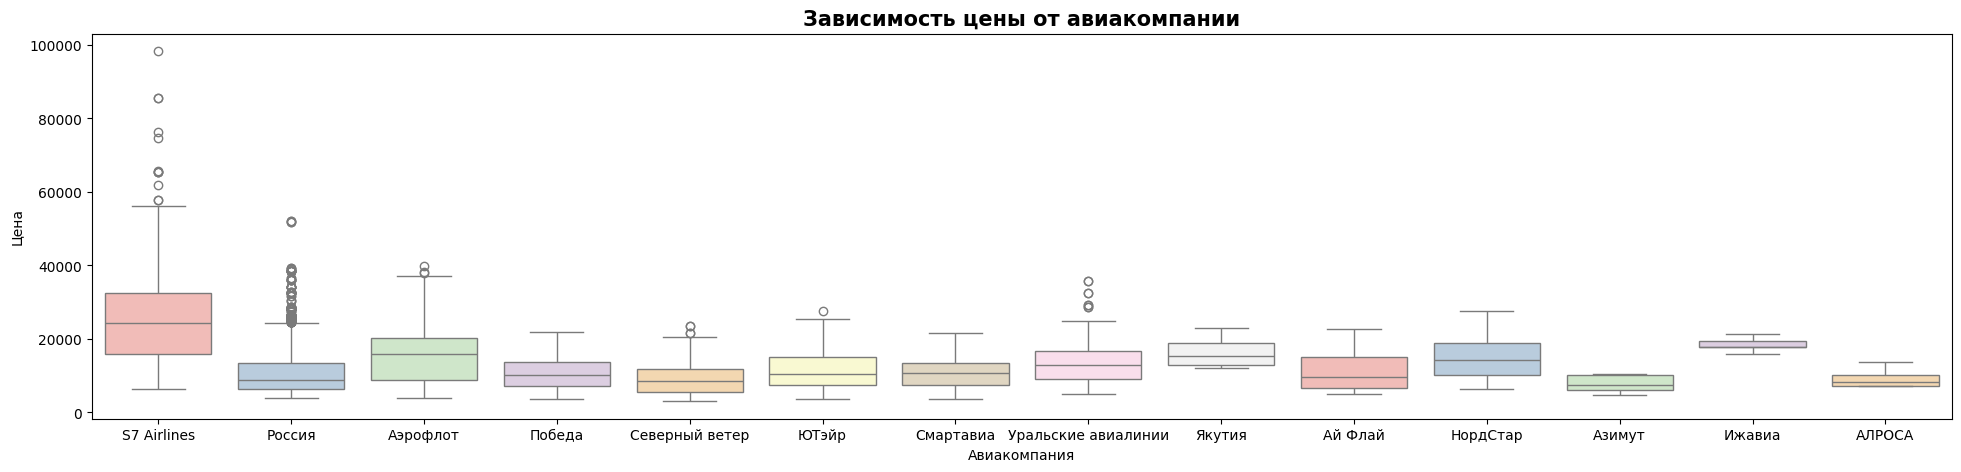

In [20]:
fig, ax3 = plt.subplots(1, 1, figsize=(24, 5))
ax3 = sns.boxplot(data = df, x='Авиакомпания', y='Цена', palette='Pastel1')

ax3.set_ylabel('Цена')
plt.title('Зависимость цены от авиакомпании', weight='bold', fontsize = 15)
plt.show()

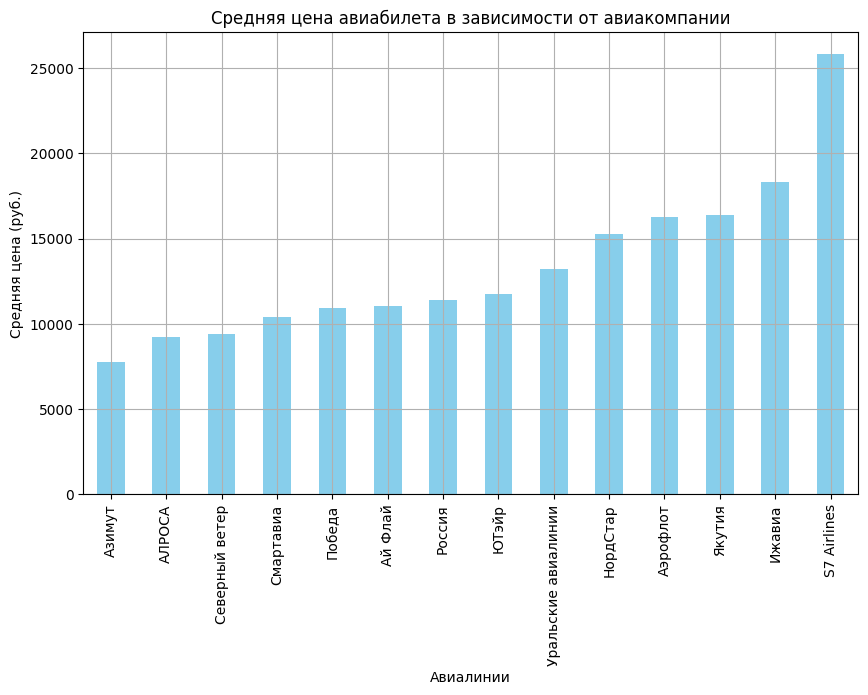

In [21]:
airline_price_avg = df.groupby('Авиакомпания')['Цена'].mean().sort_values()


plt.figure(figsize=(10, 6))
airline_price_avg.plot(kind='bar', color='skyblue')
plt.title('Средняя цена авиабилета в зависимости от авиакомпании')
plt.xlabel('Авиалинии')
plt.ylabel('Средняя цена (руб.)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


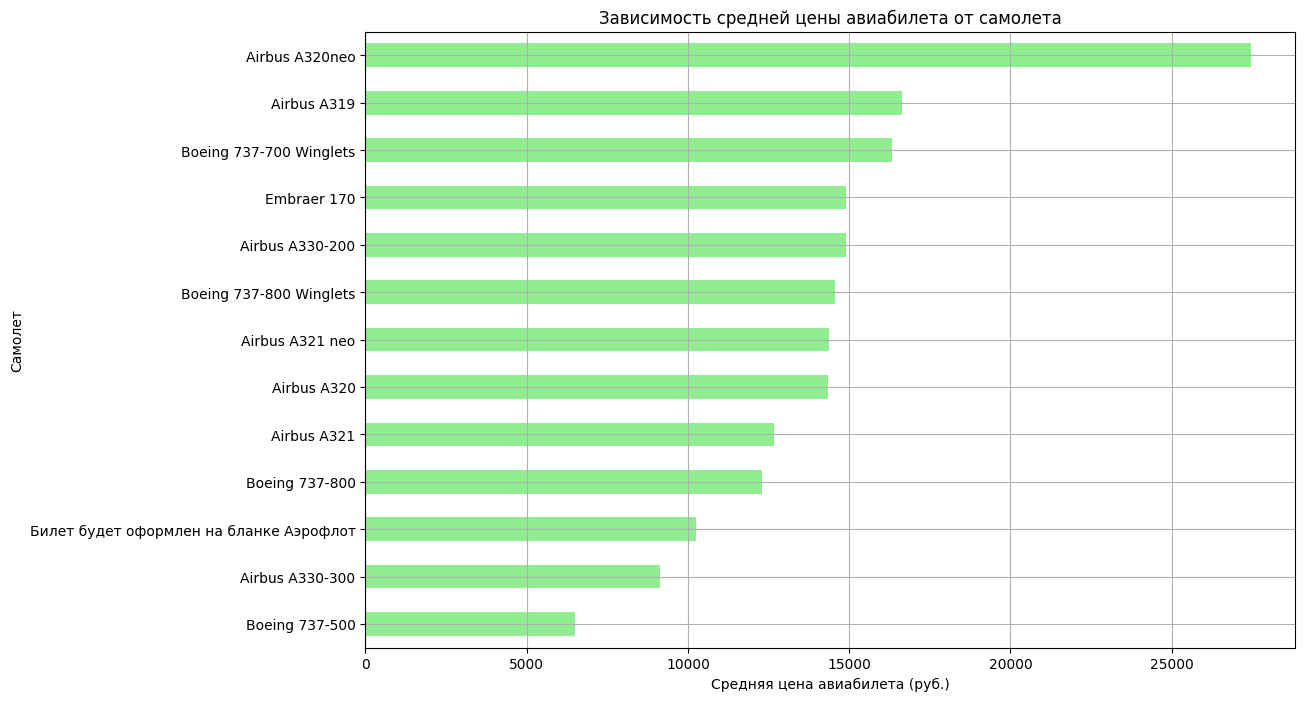

In [22]:

aircraft_price_avg = df.groupby('Самолет')['Цена'].mean().sort_values()


plt.figure(figsize=(12, 8))
aircraft_price_avg.plot(kind='barh', color='lightgreen')
plt.title('Зависимость средней цены авиабилета от самолета')
plt.xlabel('Средняя цена авиабилета (руб.)')
plt.ylabel('Самолет')
plt.grid(True)
plt.show()


In [23]:
df.to_csv('to_release2.csv')


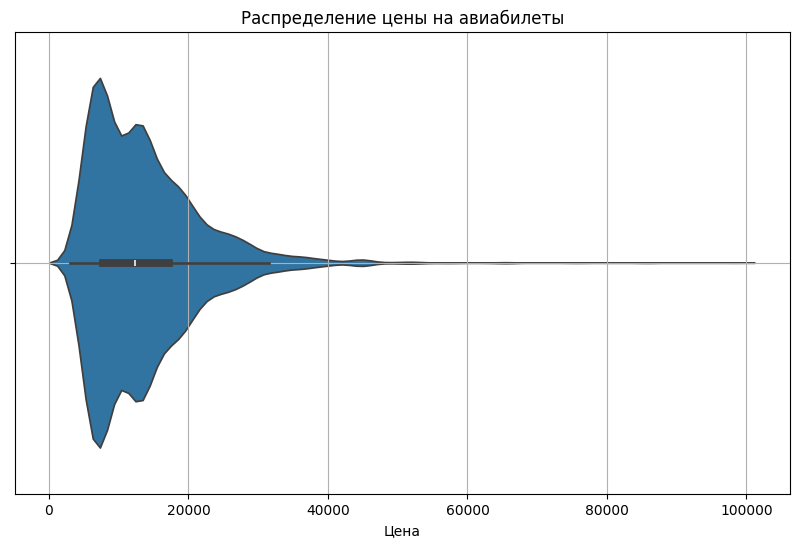

count     5595.000000
mean     13636.387846
std       8074.876450
min       3044.000000
25%       7689.000000
50%      12310.000000
75%      17264.000000
max      98292.000000
Name: Цена, dtype: float64

In [24]:
price_description = df['Цена'].describe()


plt.figure(figsize=(10, 6))
sns.violinplot(x=df['Цена'])
plt.title('Распределение цены на авиабилеты')
plt.xlabel('Цена')
plt.grid(True)
plt.show()

price_description

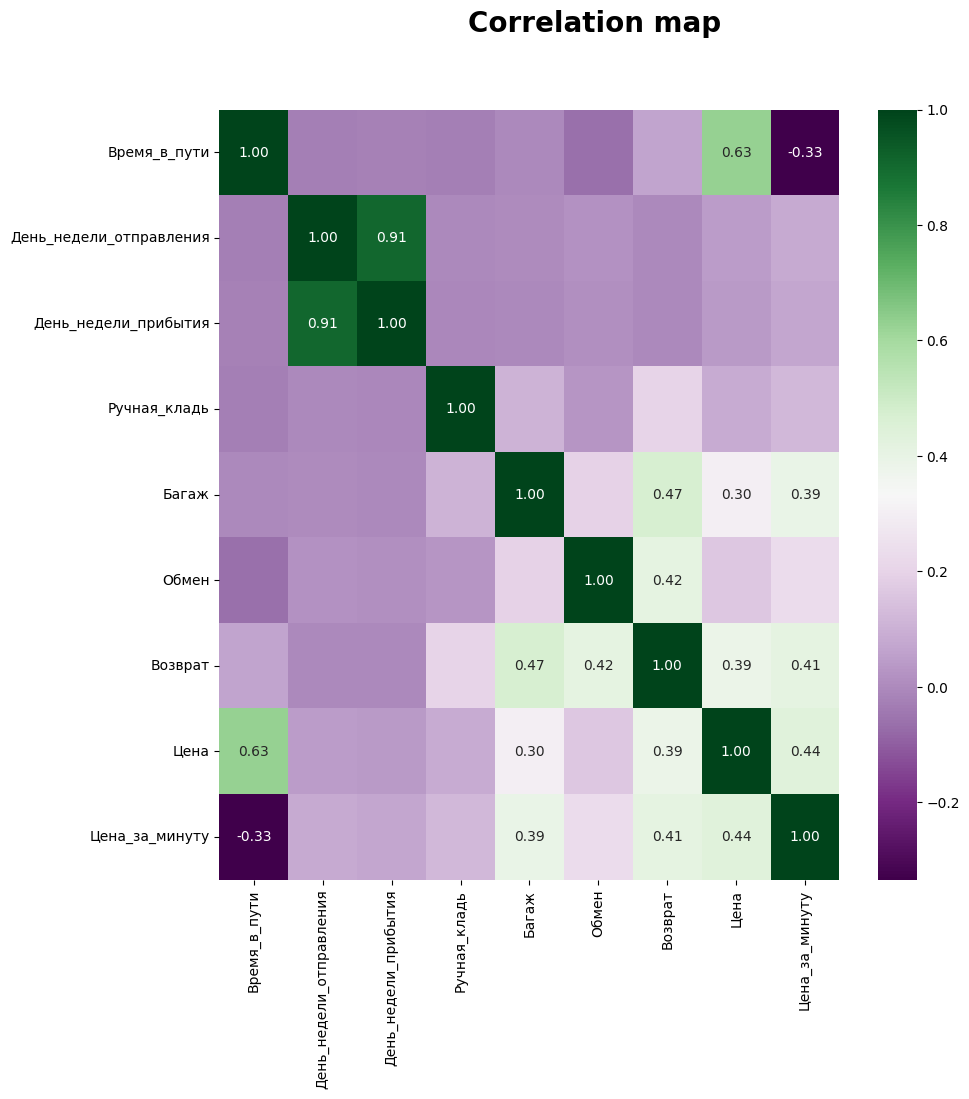

In [25]:
fig, ax_heatmap = plt.subplots(1, 1, figsize=(10, 10))

fig.suptitle('Correlation map', fontsize = 20, weight = 'bold')

ax_heatmap = sns.heatmap(df.corr(numeric_only=True), cmap = 'PRGn', annot=True, fmt="0.2f", ax=ax_heatmap)
for t in ax_heatmap.texts:
    if float(t.get_text()) >= 0.25 or float(t.get_text()) <= -0.25:
        t.set_text(t.get_text())
    else:
        t.set_text("")

plt.show()

### Пояснение полученных взаимосвязей

1. Цена сильно положительно связана со временем в пути, поскольку время в пути является прокси-переменной для расстояния и увеличивает топливные и иные издержки авиаперевозчика.

2. Опции багажного места, обмена билета и возврата, как правило, идут вместе в едином тарифе (так, у некоторых авиакомпаний существует деление эконом-класса на более дешевый и дорогой варианты, где в дешевом отсутствуют все эти опции, а в дорогом они есть)

3. Отсутствие значимых корреляций цены с другими признаками говорит о возможной нелинейной взаимосвязи между ними (которую плохо определяет коэффициент корреляции), о неоднородности данных (взяты билеты с разной продолжительностью полета и разными направлениями, а также для авиакомпаний из разных ценовых категорий - таким образом, потребности разных целевый аудиторий, выраженные в цене билета, могут существенно отличаться и в итоге демонстировать отсутствие взаимосвязи на общей выборке), а также о необходимости введения дополнительных переменных на основе существующих (например, далее мы введем переменную 'Цена за минуту' для сравнения билетов с разным временем в пути)

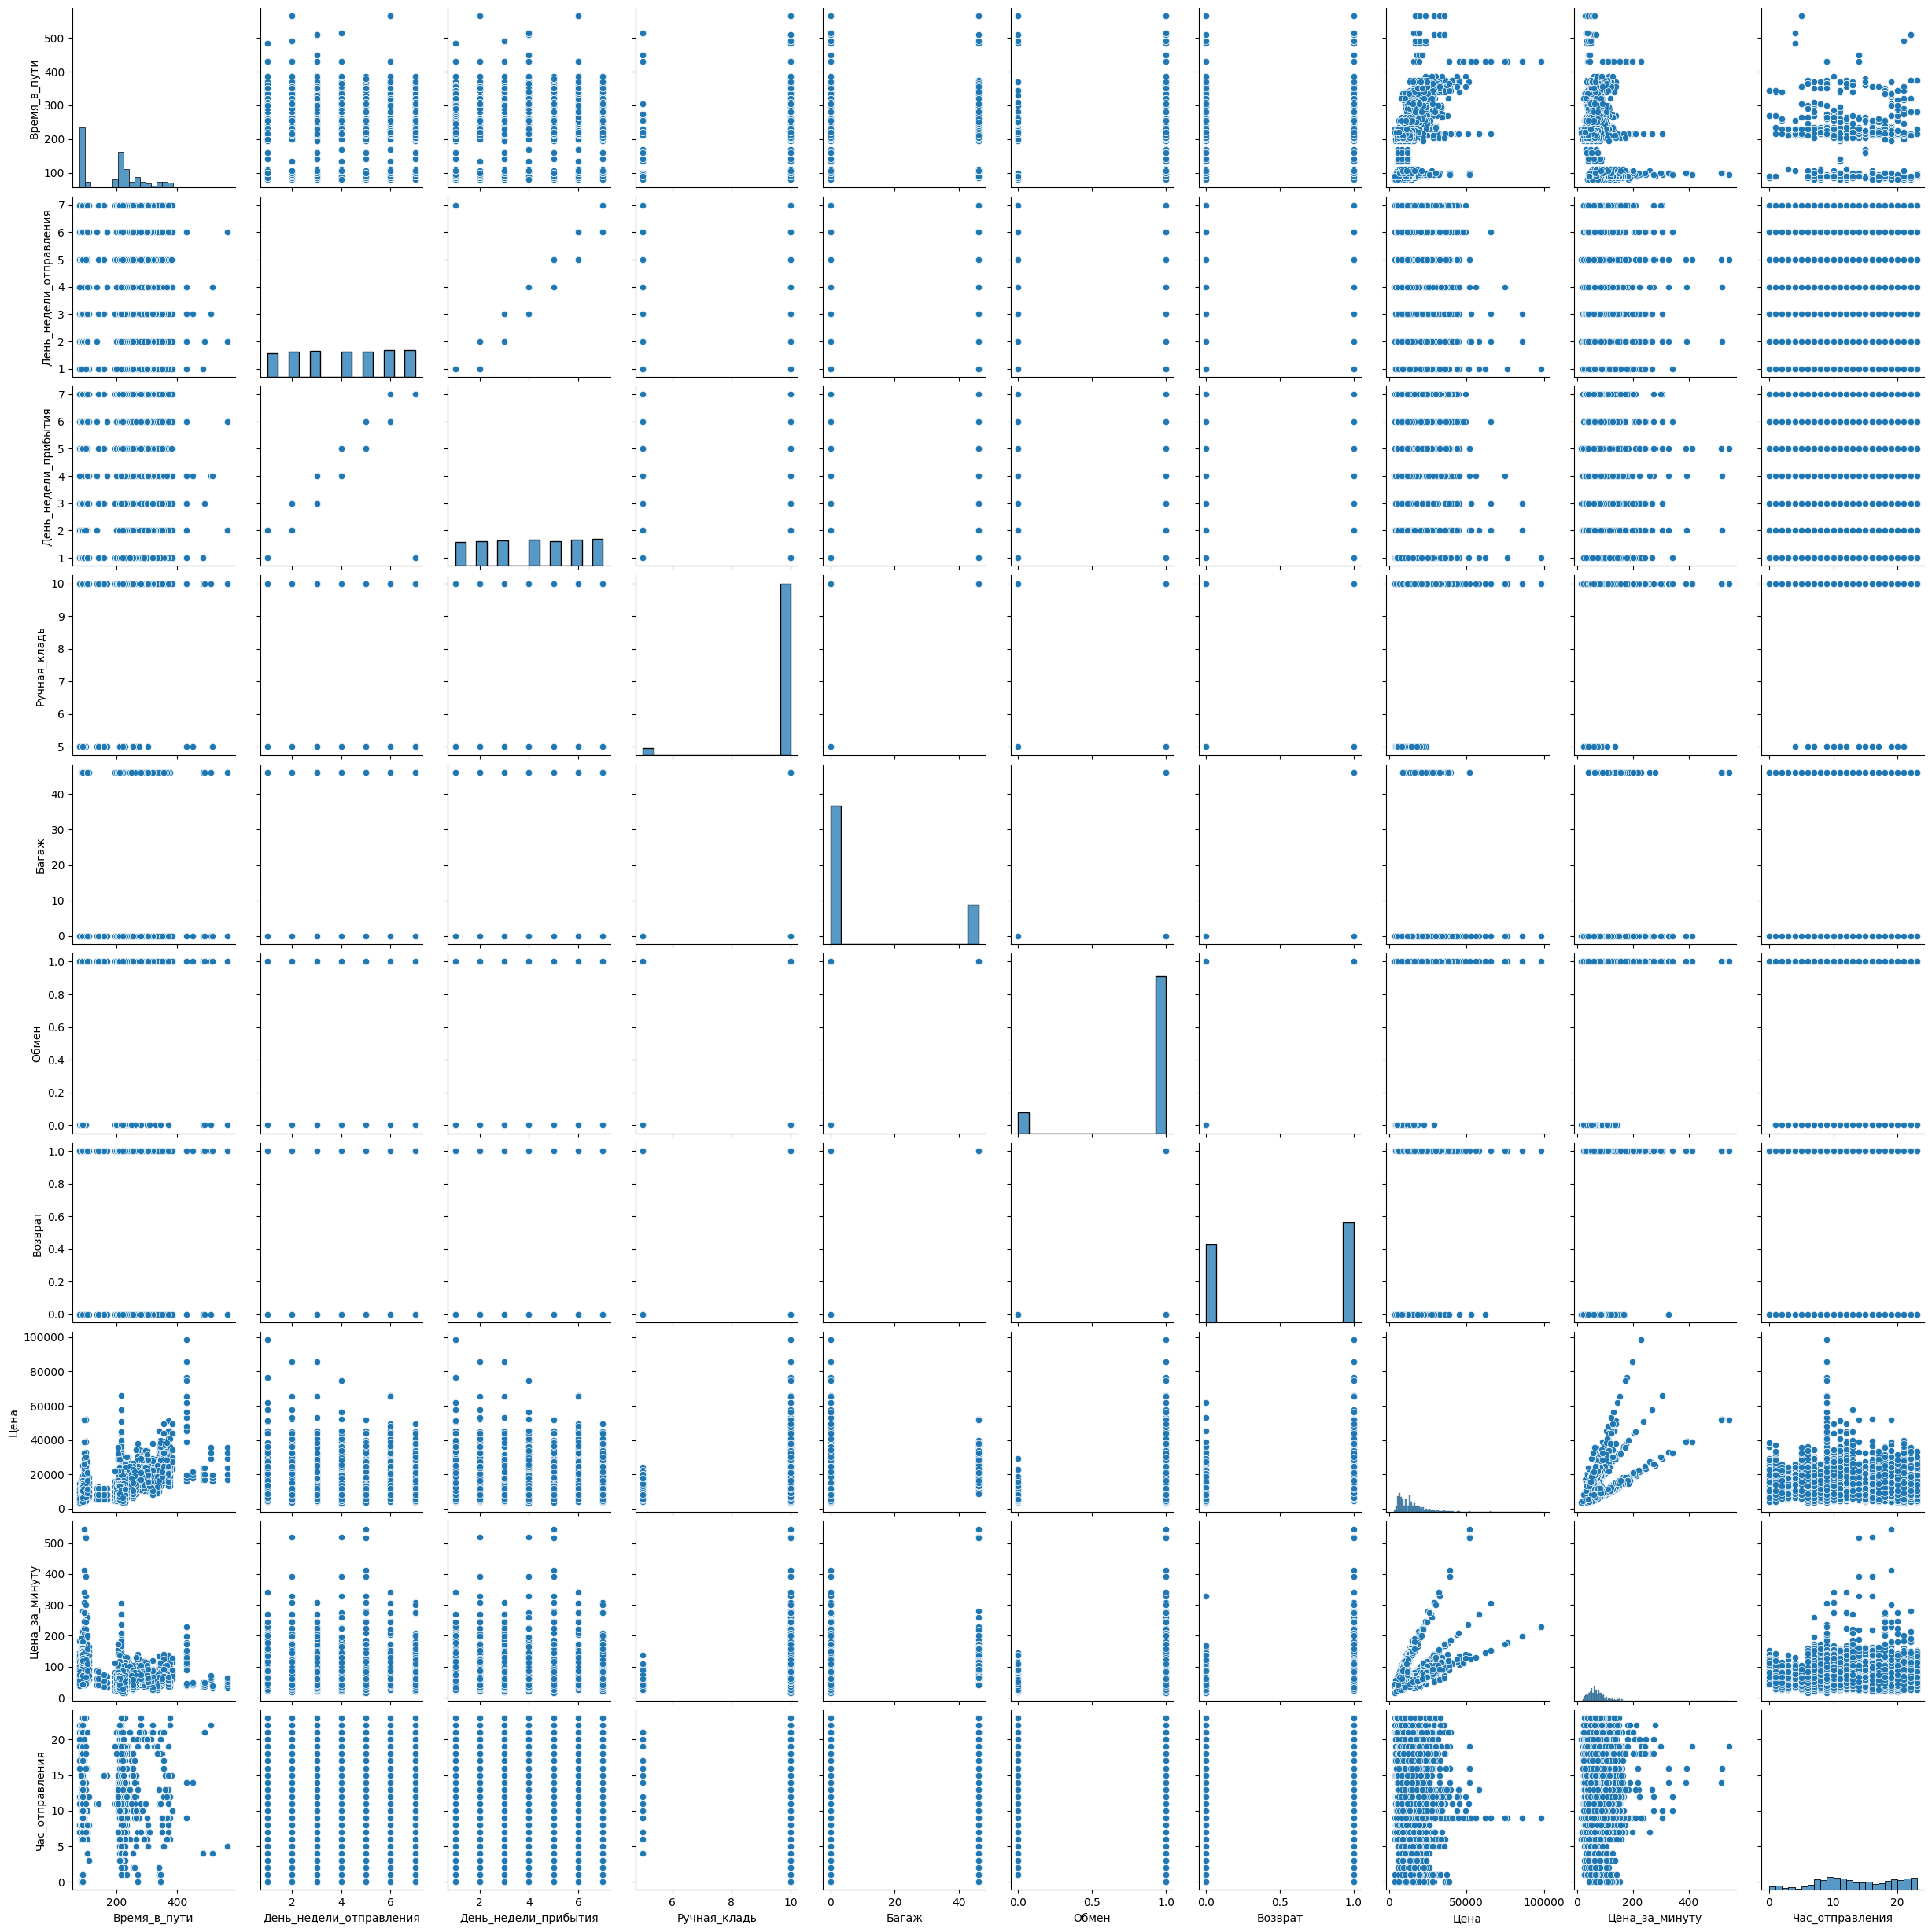

In [29]:
sns.pairplot(df)

In [28]:
df.shape

(5595, 20)

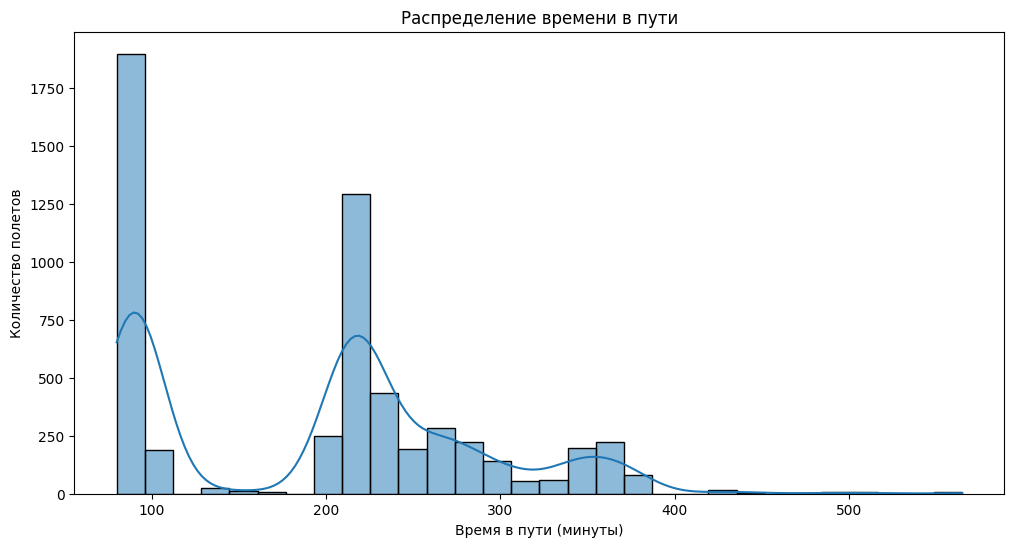

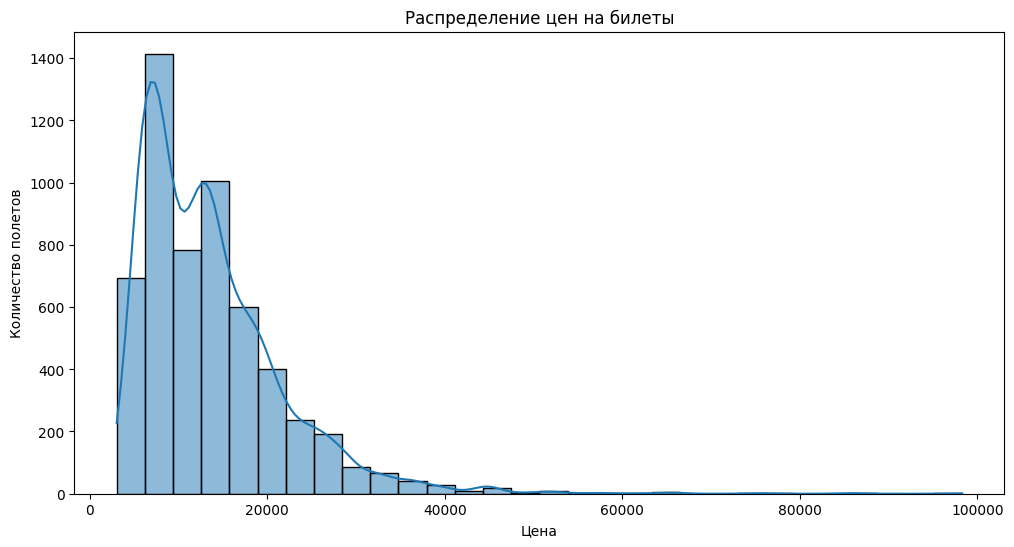

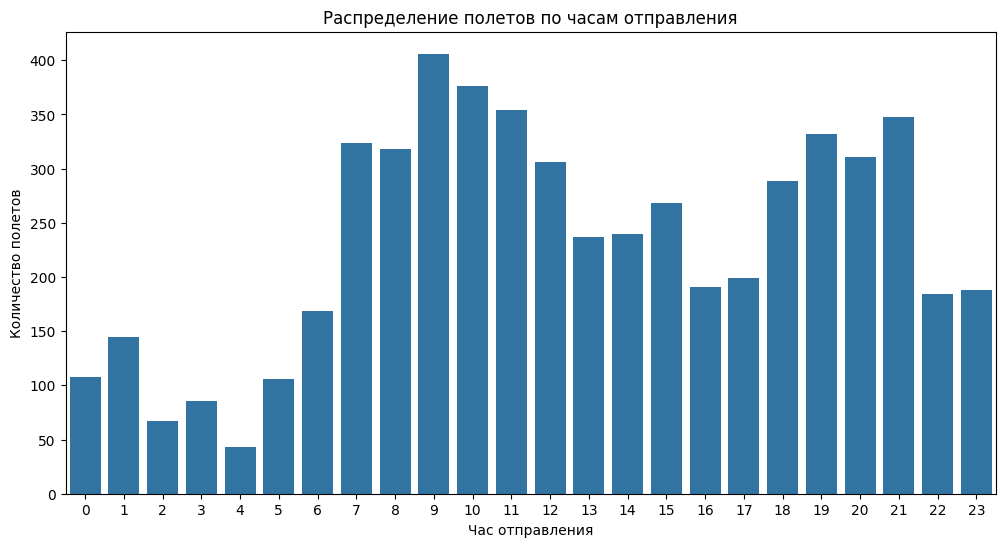

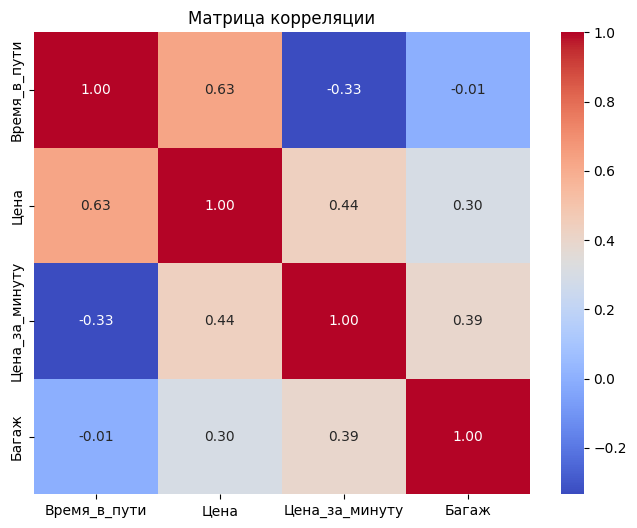

In [27]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Время_в_пути'], bins=30, kde=True)
plt.title('Распределение времени в пути')
plt.xlabel('Время в пути (минуты)')
plt.ylabel('Количество полетов')
plt.show()

# Распределение цен
plt.figure(figsize=(12, 6))
sns.histplot(df['Цена'], bins=30, kde=True)
plt.title('Распределение цен на билеты')
plt.xlabel('Цена')
plt.ylabel('Количество полетов')
plt.show()

# Время отправления
df['Время_отправления'] = pd.to_datetime(df['Время_отправления'])
df['Час_отправления'] = df['Время_отправления'].dt.hour

plt.figure(figsize=(12, 6))
sns.countplot(x='Час_отправления', data=df)
plt.title('Распределение полетов по часам отправления')
plt.xlabel('Час отправления')
plt.ylabel('Количество полетов')
plt.show()

# Корреляция основных числовых переменных
correlation_matrix = df[['Время_в_пути', 'Цена', 'Цена_за_минуту', 'Багаж']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

**Распределение времени в пути:**

- Время в пути имеет несколько пиков, что может указывать на наличие типичных продолжительностей для определённых направлений. Особенно ярко выражены пики около 100 минут и более 200 минут.

**Распределение цен на билеты:**

- Распределение цен скошено вправо, что означает наличие немалого количества дорогих билетов по сравнению с более дешёвыми.  

- Большинство билетов сконцентрировано в более низком ценовом диапазоне.

**Распределение полетов по часам отправления:**

- Большинство полетов сконцентрировано в утренние и вечерние часы, с пиками около 7 утра и 8 вечера. Это типичное распределение, подчеркивающее предпочтения пассажиров вылетать утром или вечером.

**Матрица корреляции:**

Наблюдается положительная корреляция между временем в пути и ценой, что логично, так как более длительные полеты часто стоят дороже.

**Гипотезы для проверки:**

1. Цена зависит от времени отправления - проверить, есть ли значимые различия в ценах на билеты в зависимости от времени суток.

2. День недели влияет на цену билета - проверить, изменяется ли средняя цена билета в зависимости от дня недели.

3. Влияние авиакомпании на цену - исследовать, как различные авиакомпании устанавливают цены на билеты.

### Проверка гипотез

#### Гипотеза 1: цена не зависит от времени отправления

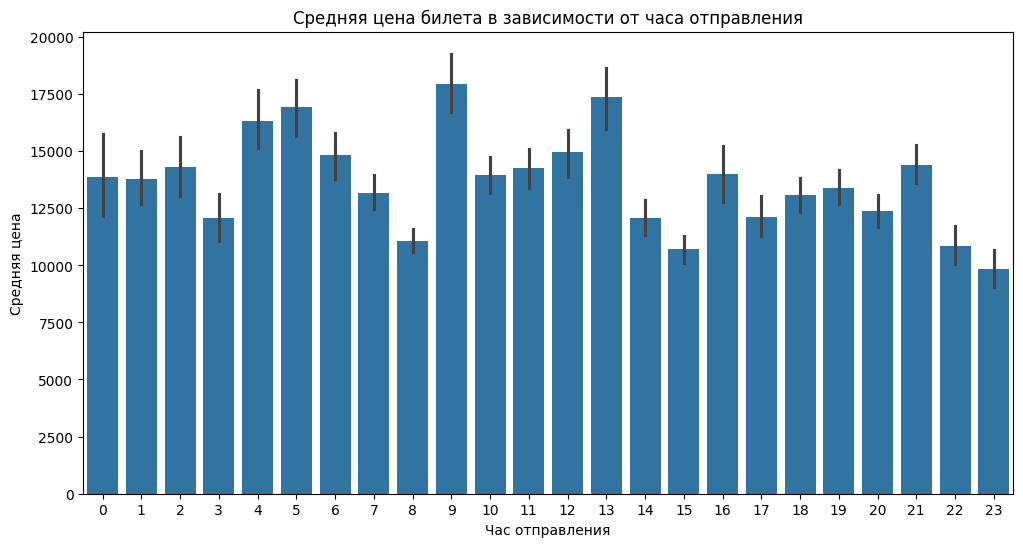

,sum_sq,df,F,PR(>F)
C(Час_отправления),2.390474e+10,23.0,16.987647,5.040580e-66
Residual,3.408444e+11,5571.0,NaN,NaN


In [30]:
hourly_price_mean = df.groupby('Час_отправления')['Цена'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Час_отправления', y='Цена', data=df)
plt.title('Средняя цена билета в зависимости от часа отправления')
plt.xlabel('Час отправления')
plt.ylabel('Средняя цена')
plt.show()


model = ols('Цена ~ C(Час_отправления)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


**Средняя цена билета в зависимости от часа отправления:**

График показывает, что существуют заметные колебания в средних ценах в зависимости от часа отправления. Например, билеты, отправляющиеся в ночные и ранние утренние часы, как правило, дешевле.

**ANOVA тест:**

Результаты ANOVA теста подтверждают, что есть статистически значимые различия в ценах на билеты в зависимости от часа отправления (p-значение $\approx 5.04\cdot 10 ^{-66}$), что чрезвычайно мало и позволяет отвергнуть нулевую гипотезу о том, что средние цены равны для всех групп времени отправления.

#### Гипотеза 2: цена не зависит от дня недели отправления

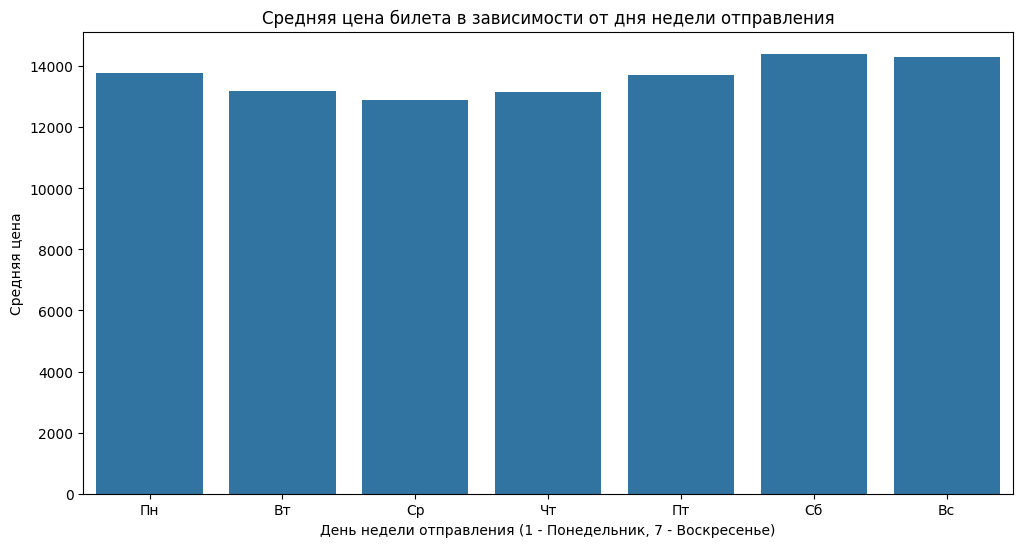

,sum_sq,df,F,PR(>F)
C(День_недели_отправления),1.675389e+09,6.0,4.2976,0.000249
Residual,3.630737e+11,5588.0,NaN,NaN


In [37]:
weekday_price_mean = df.groupby('День_недели_отправления')['Цена'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='День_недели_отправления', y='Цена', data=weekday_price_mean)
plt.title('Средняя цена билета в зависимости от дня недели отправления')
plt.xlabel('День недели отправления (1 - Понедельник, 7 - Воскресенье)')
plt.ylabel('Средняя цена')
plt.xticks(ticks=range(0, 7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

model_weekday = ols('Цена ~ C(День_недели_отправления)', data=df).fit()
anova_weekday_table = sm.stats.anova_lm(model_weekday, typ=2)
anova_weekday_table


**Средняя цена билета в зависимости от дня недели отправления:**

График показывает, что существуют различия в средней цене билетов в зависимости от дня недели. В частности, билеты в понедельник и выходные кажутся дороже, чем в остальные дни.

**ANOVA тест:**

Результаты ANOVA теста подтверждают наличие статистически значимых различий в средних ценах билетов по дням недели (p-значение $\approx 0.0000249$, что позволяет отвергнуть нулевую гипотезу о равенстве средних цен по всем дням.

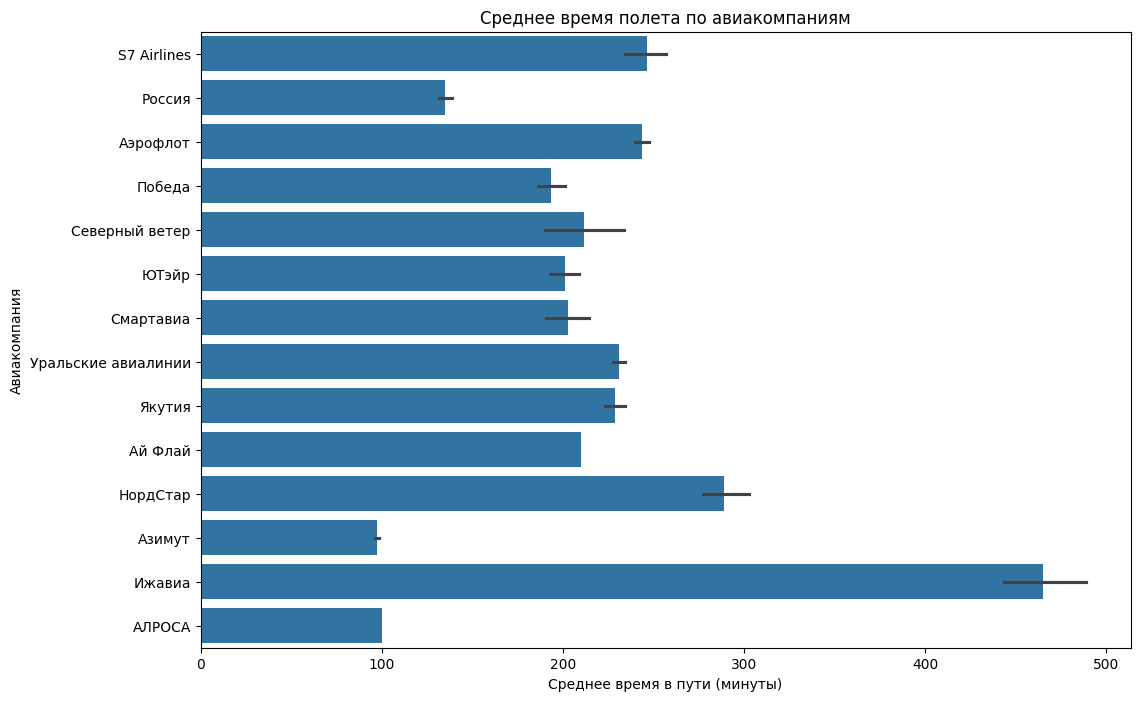

In [38]:
airline_flight_time_mean = df.groupby('Авиакомпания')['Время_в_пути'].mean().sort_values().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='Время_в_пути', y='Авиакомпания', data=df)
plt.title('Среднее время полета по авиакомпаниям')
plt.xlabel('Среднее время в пути (минуты)')
plt.ylabel('Авиакомпания')
plt.show()


#### Гипотеза 3: нет различий между разными авиакомпаниями при установке цены

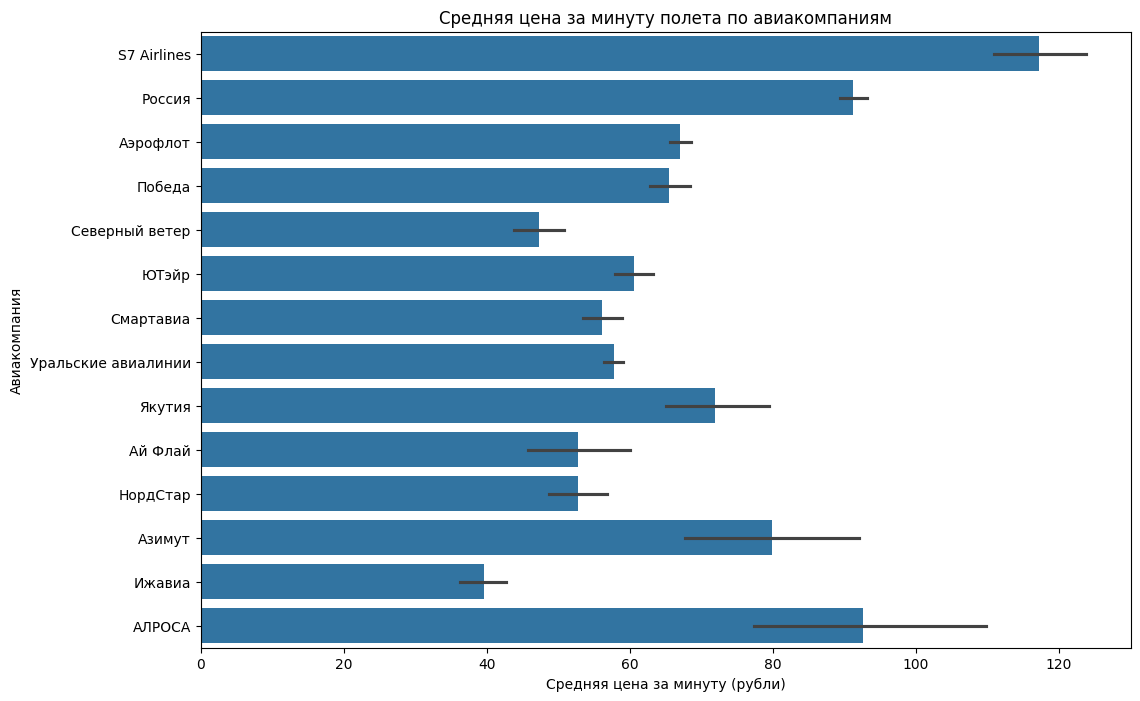

In [39]:
airline_price_per_minute_mean = df.groupby('Авиакомпания')['Цена_за_минуту'].mean().sort_values().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='Цена_за_минуту', y='Авиакомпания', data=df)
plt.title('Средняя цена за минуту полета по авиакомпаниям')
plt.xlabel('Средняя цена за минуту (рубли)')
plt.ylabel('Авиакомпания')
plt.show()


#### Гипотеза 4: если по маршруту выполняется малое количество рейсов, то цена авиабилетов по данному маршруту выше

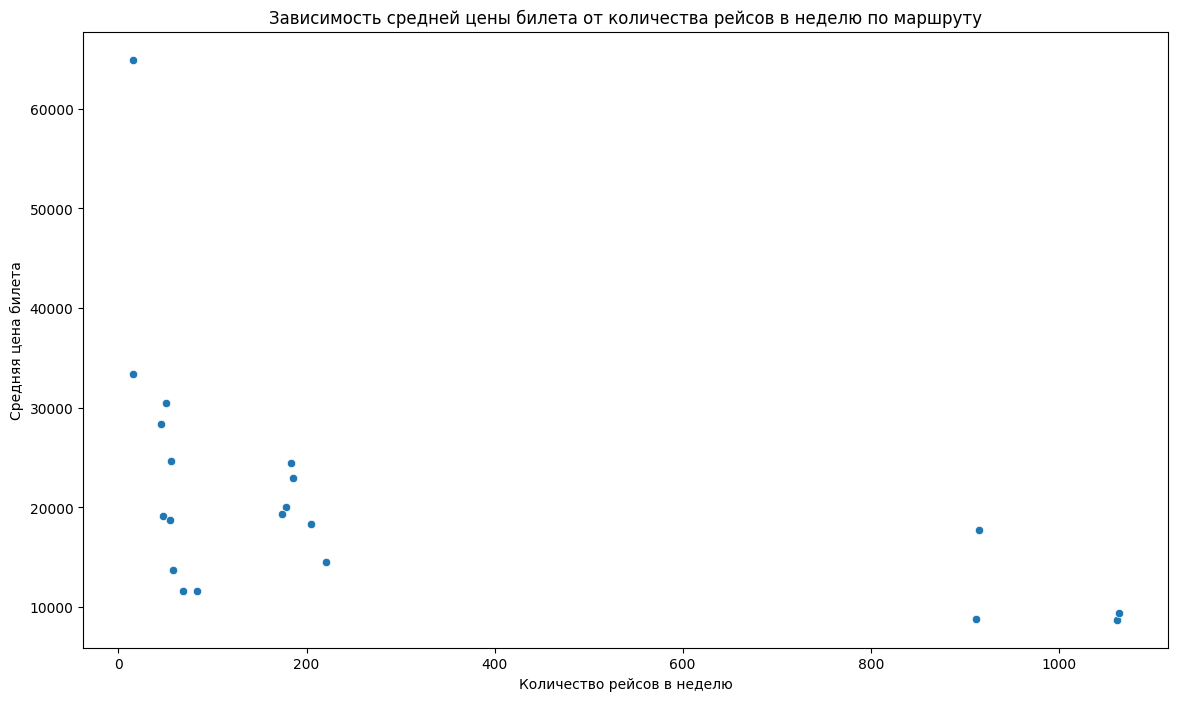

-0.4682857696672767

In [40]:
flights_per_week = df.groupby('Направление')['Дата_отправления'].count().reset_index()
flights_per_week.rename(columns={'Дата_отправления': 'Рейсы_в_неделю'}, inplace=True)

average_price_per_route = df.groupby('Направление')['Цена'].mean().reset_index()

route_analysis = pd.merge(flights_per_week, average_price_per_route, on='Направление')

plt.figure(figsize=(14, 8))
sns.scatterplot(x='Рейсы_в_неделю', y='Цена', data=route_analysis)
plt.title('Зависимость средней цены билета от количества рейсов в неделю по маршруту')
plt.xlabel('Количество рейсов в неделю')
plt.ylabel('Средняя цена билета')
plt.show()

correlation = route_analysis['Рейсы_в_неделю'].corr(route_analysis['Цена'])
correlation


Полученная взаимосвязь показывает, что при наличии большего количества альтернатив у пассажиров авиакомпании вынуждены конкурировать между собой (а иногда конкуренция возникает и между их собственными продуктами - билетами на одно направление в разное время и даты) и снижать цену, чтобы привлечь покупателей. 

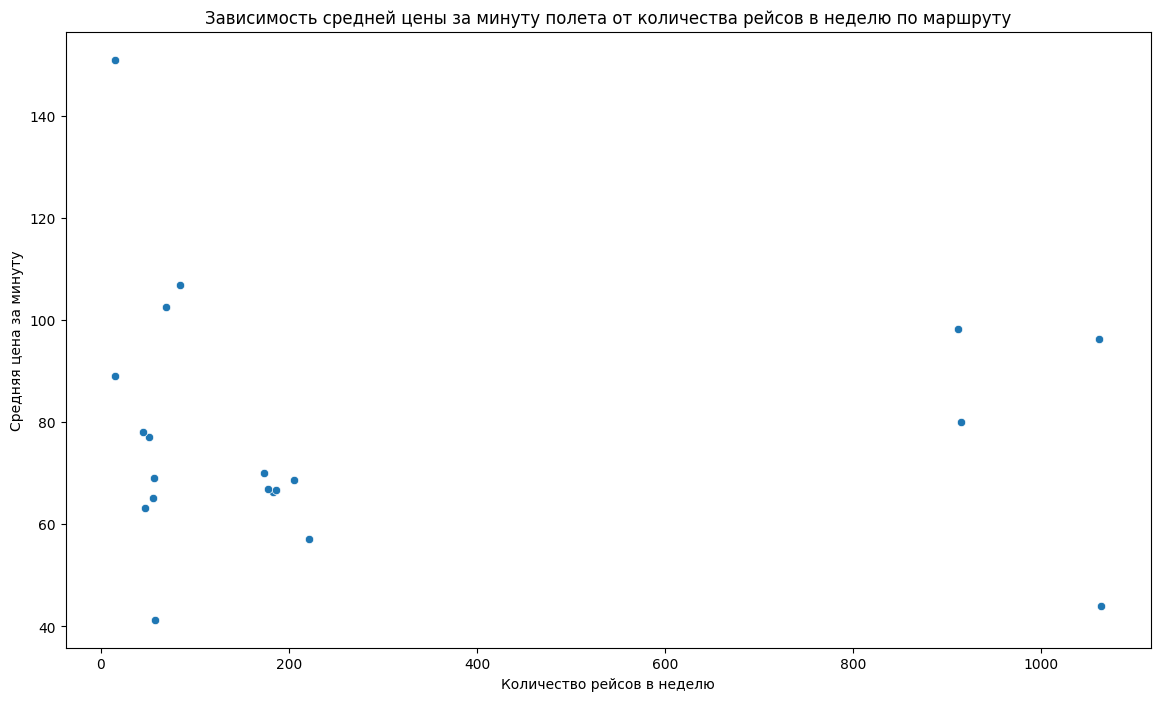

-0.05035475676759509

In [41]:

average_price_per_minute_per_route = df.groupby('Направление')['Цена_за_минуту'].mean().reset_index()


route_price_per_minute_analysis = pd.merge(flights_per_week, average_price_per_minute_per_route, on='Направление')


plt.figure(figsize=(14, 8))
sns.scatterplot(x='Рейсы_в_неделю', y='Цена_за_минуту', data=route_price_per_minute_analysis)
plt.title('Зависимость средней цены за минуту полета от количества рейсов в неделю по маршруту')
plt.xlabel('Количество рейсов в неделю')
plt.ylabel('Средняя цена за минуту')
plt.show()


correlation_price_per_minute = route_price_per_minute_analysis['Рейсы_в_неделю'].corr(route_price_per_minute_analysis['Цена_за_минуту'])
correlation_price_per_minute


#### Гипотеза 5: цена на авиабилеты не зависит от самолета 

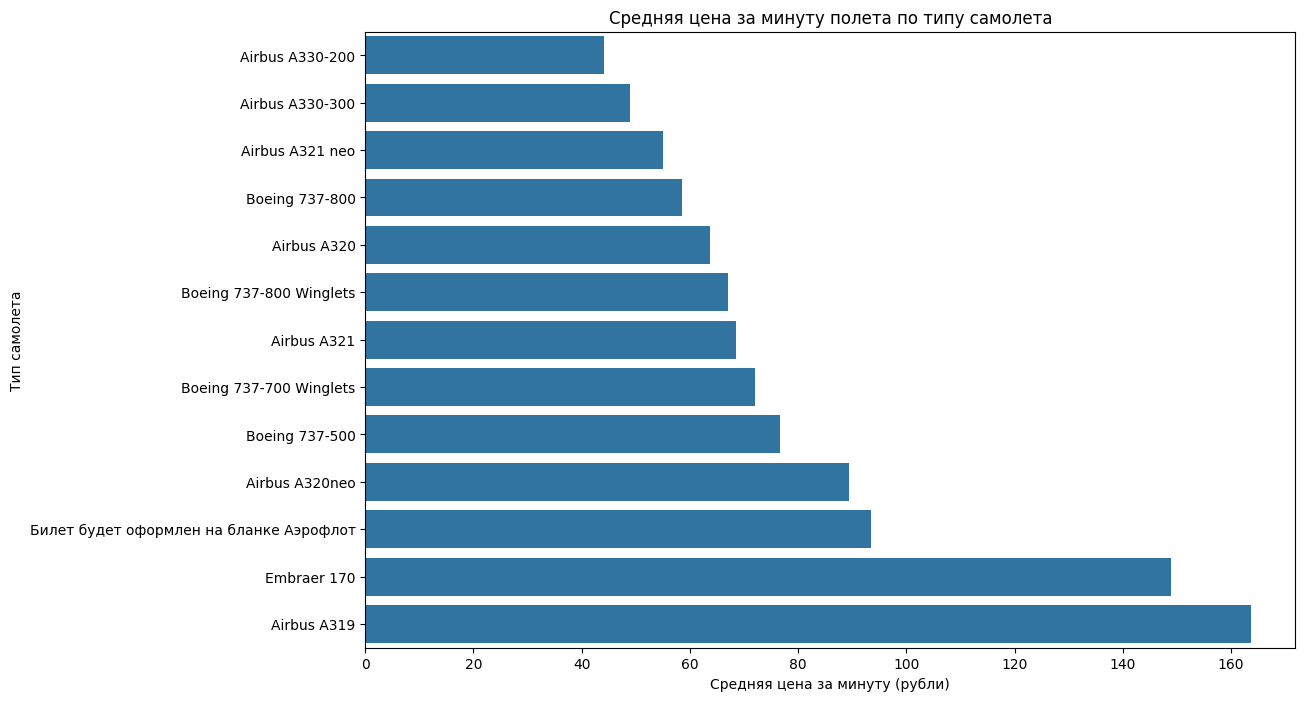

In [42]:

average_price_per_minute_per_plane = df.groupby('Самолет')['Цена_за_минуту'].mean().sort_values().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='Цена_за_минуту', y='Самолет', data=average_price_per_minute_per_plane)
plt.title('Средняя цена за минуту полета по типу самолета')
plt.xlabel('Средняя цена за минуту (рубли)')
plt.ylabel('Тип самолета')
plt.show()


Вывод: 
1. Цена за минуту все же зависит от типа самолета. Однако как будет выяснено позднее, цена за минуту очень сильно зависит от длительности рейса, и полученные выводы могут быть связаны с тем, что те или иные модели самолета скорее используются для более дальних или более близких перелетов. 
2. Другой важный вывод, который можно точно сделать из данного графика - это зависимость между вместимостью самолета и ценой за минуту. На примере линейки моделей компании Airbus можно заметить, что более вместительные самолеты дешевле обходятся для потребителей, чем более маленькие. Это связано с тем, что у авиакомпаний присутствуют достаточно большие фиксированные издержки, и при большой вместимости самолета эти косты распределяются по большему количеству пассажиров. 

#### Анализ связи цены за минуту полета от услуг, входящих в билет (размер багажа и ручной клади, возможность обмена и возврата)

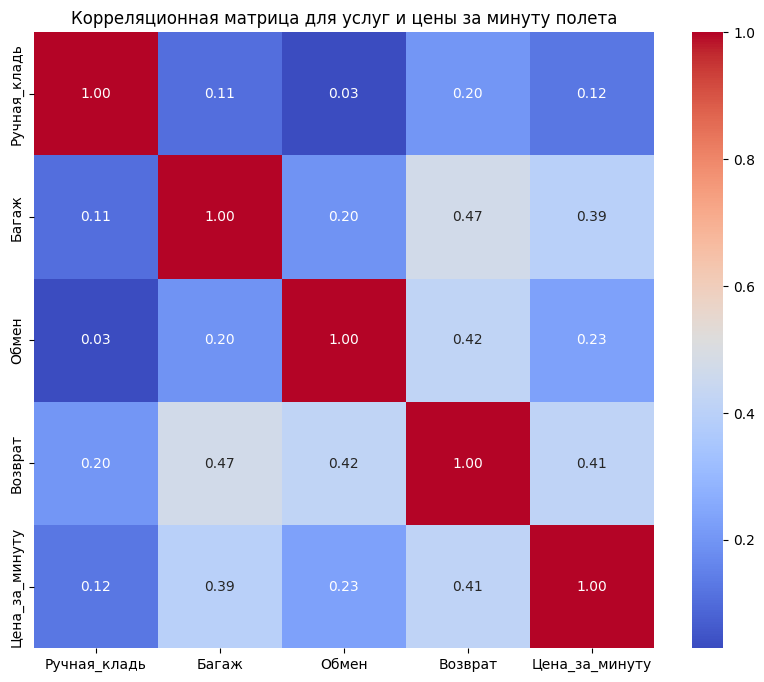

In [43]:

features_per_minute = ['Ручная_кладь', 'Багаж', 'Обмен', 'Возврат', 'Цена_за_минуту']

correlation_matrix_services_per_minute = df[features_per_minute].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_services_per_minute, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица для услуг и цены за минуту полета')
plt.show()


Вывод: сильных корреляций между признаками и ценой за минуту не наблюдается, относительно выделяются те же признаки, что и были при корреляционном анализе с обычной ценой. 

#### Анализ специализации авиакомпаний по длине полетов

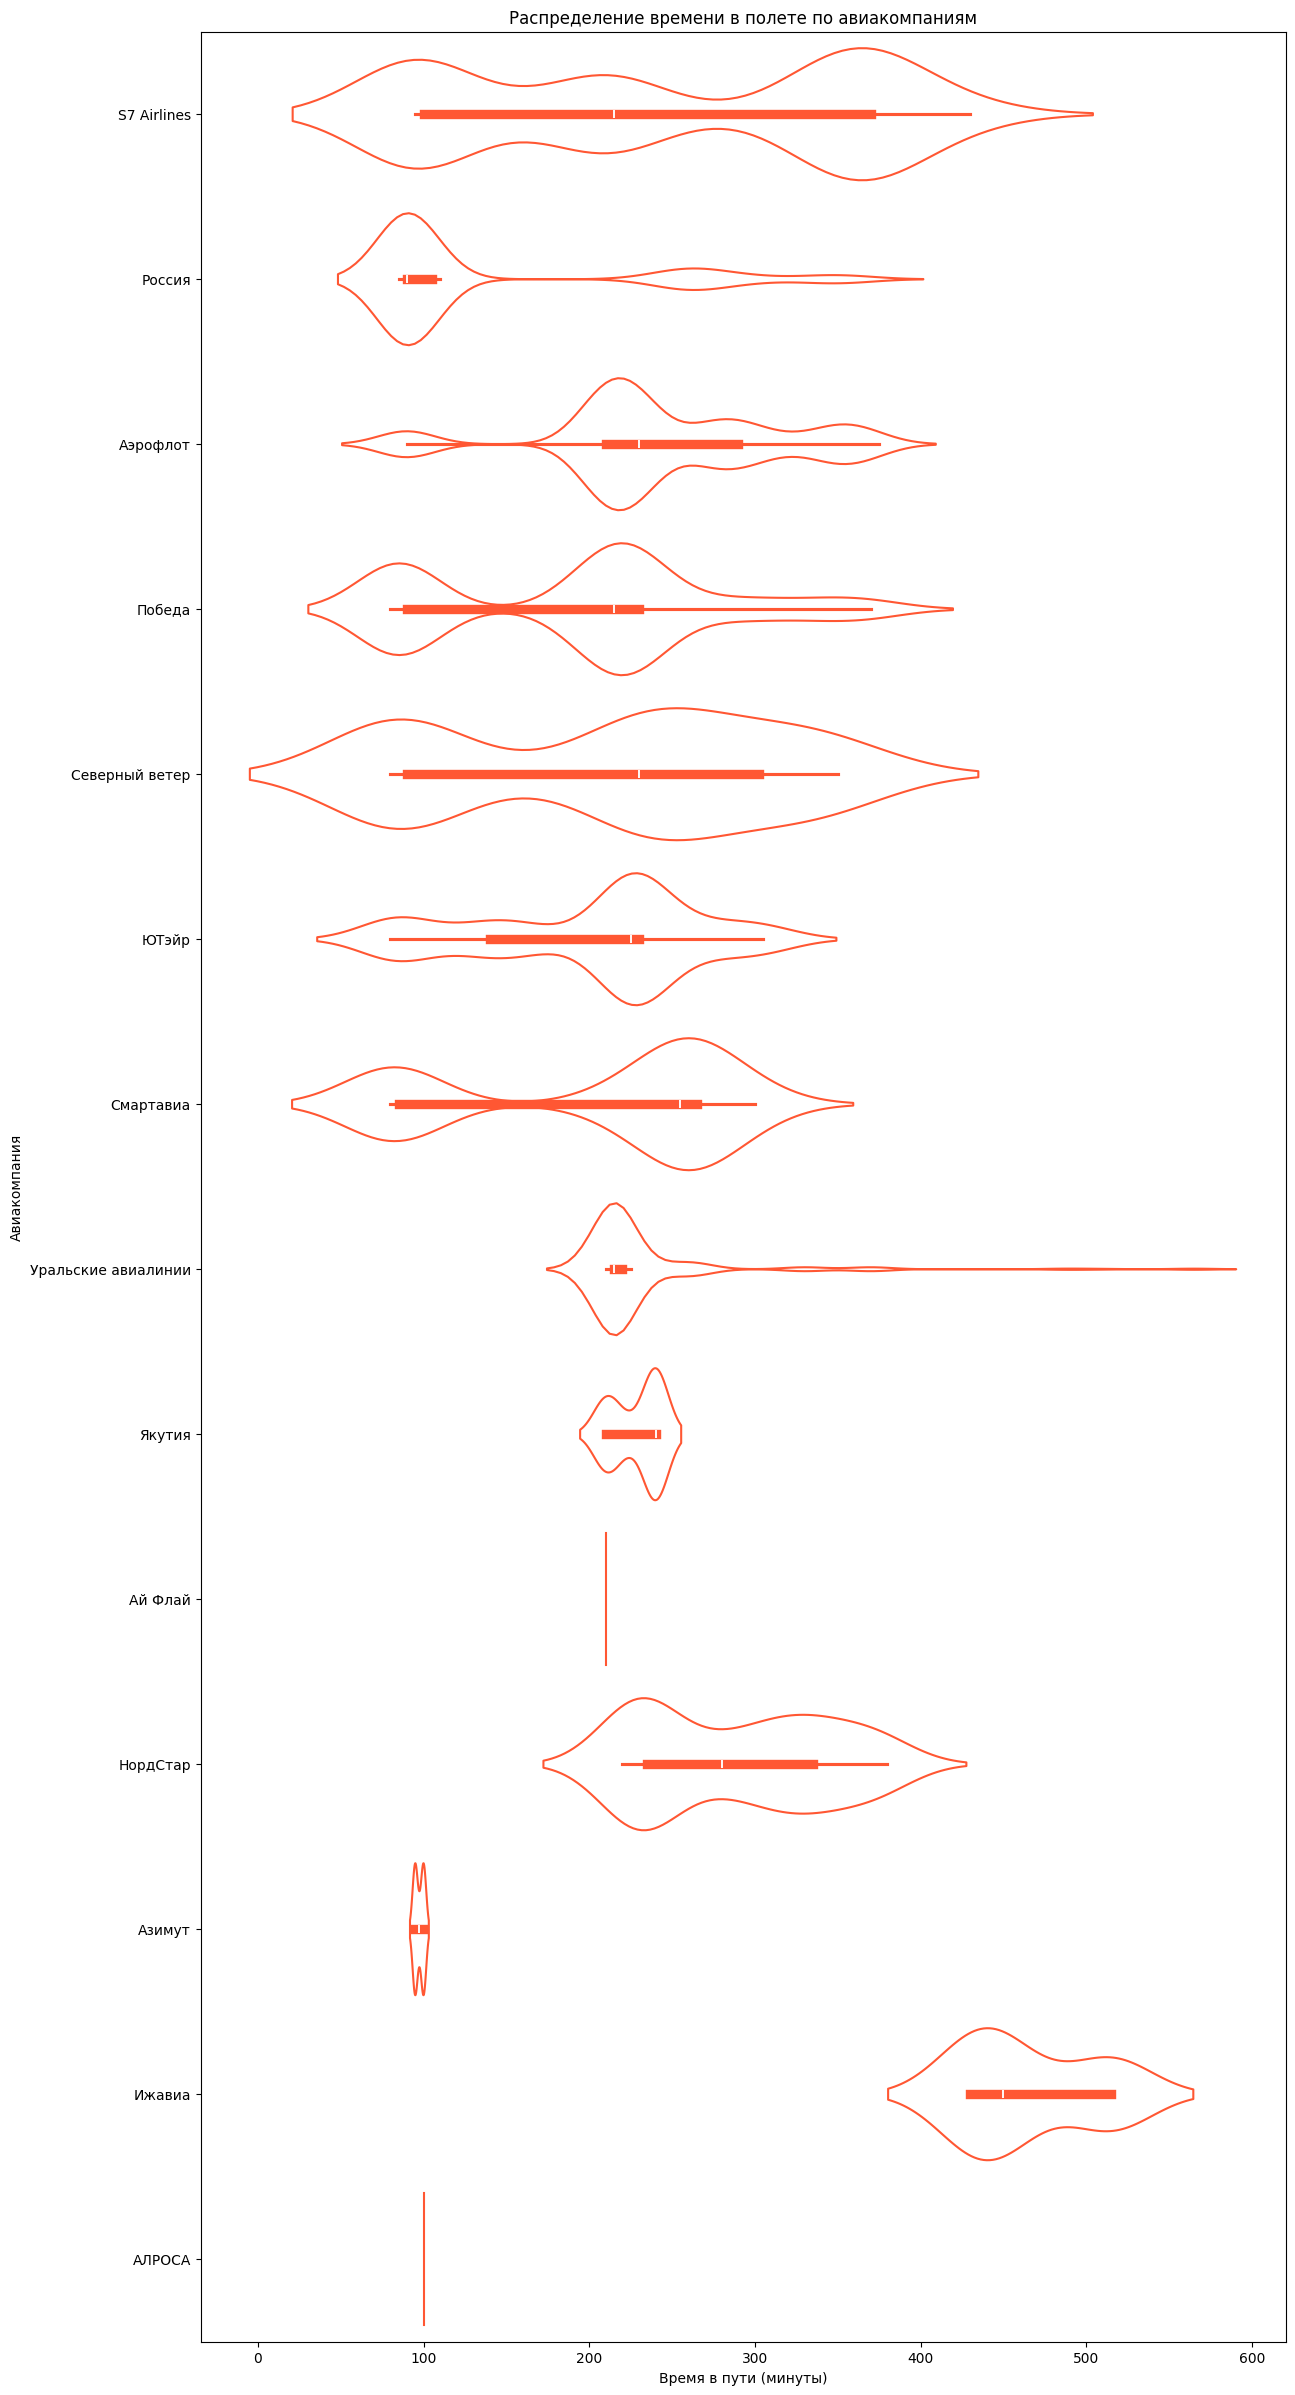

In [44]:
custom_palette = ["#FF5733"]
plt.figure(figsize=(14, 30))
sns.violinplot(x='Время_в_пути', y='Авиакомпания', data=df, palette=custom_palette, fill=False)
plt.title('Распределение времени в полете по авиакомпаниям')
plt.xlabel('Время в пути (минуты)')
plt.ylabel('Авиакомпания')
plt.show()


#### Вывод

Выделяются авиакомпании, которые в основном специализируются на каком-то одном типе рейсов (длинные, короткие или средние), а также компании-универсалы. Для продолжения анализа этой особенности компаний необходимо спарсить большее количество рейсов из разных городов. 

#### Гипотеза 6: на короткие рейсы билеты чаще всего продаются в утренние и вечерние часы, на длинные рейсы чаще в вечерние часы

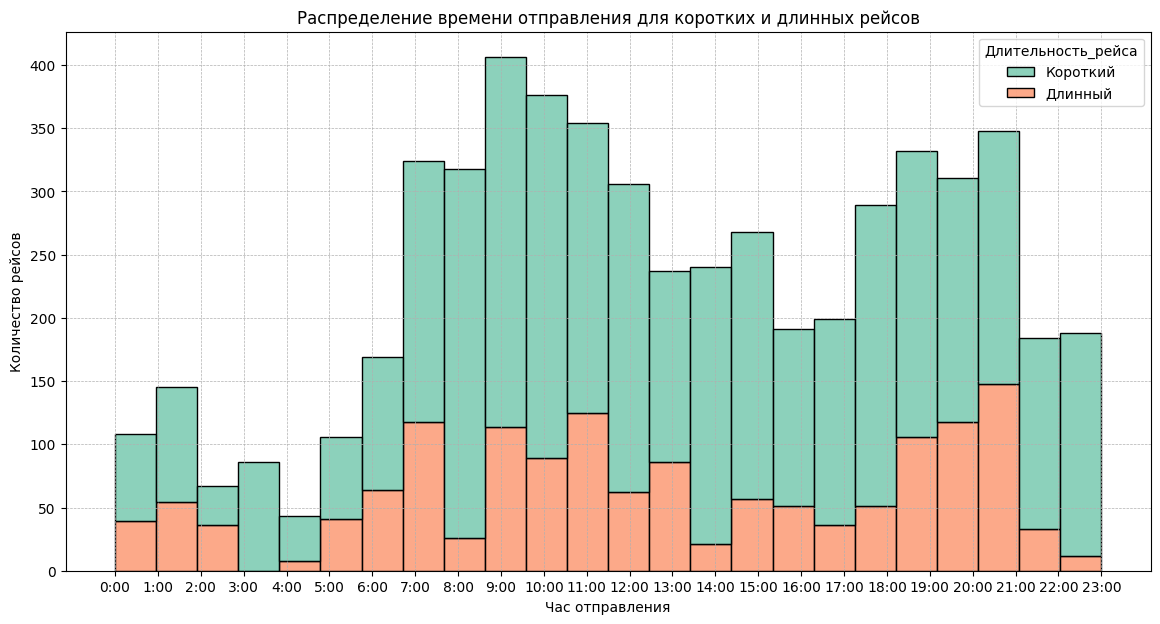

In [45]:

df['Длительность_рейса'] = pd.cut(df['Время_в_пути'], bins=[0, 240, max(df['Время_в_пути'])], labels=['Короткий', 'Длинный'])

df['Час_отправления'] = df['Время_отправления'].dt.hour


plt.figure(figsize=(14, 7))
sns.histplot(data=df, x='Час_отправления', hue='Длительность_рейса', multiple='stack', bins=24, palette='Set2')
plt.title('Распределение времени отправления для коротких и длинных рейсов')
plt.xlabel('Час отправления')
plt.ylabel('Количество рейсов')
plt.xticks(ticks=range(0, 24), labels=[f"{hour}:00" for hour in range(0, 24)])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Вывод: из анализа времени отправления можно сделать следующие выводы:
1. В целом потребители склонны выезжать или в первой половине дня (особенно это касается коротких рейсов), чтобы добраться к заселению в отель (обычно после 14:00) и не потерять день в дороге; или ближе к вечеру (после работы)
2. При этом пассажиры длинных рейсов предпочитают вылет в утренние часы (возможность доехать в адекватное время до пункта назначения со сменой часового пояса) или ближе к вечеру или даже ночи (возможность поспать в пути)

#### Анализ стоимости авиабилета от количества авиакомпаний выполняющих полеты по данному маршруту

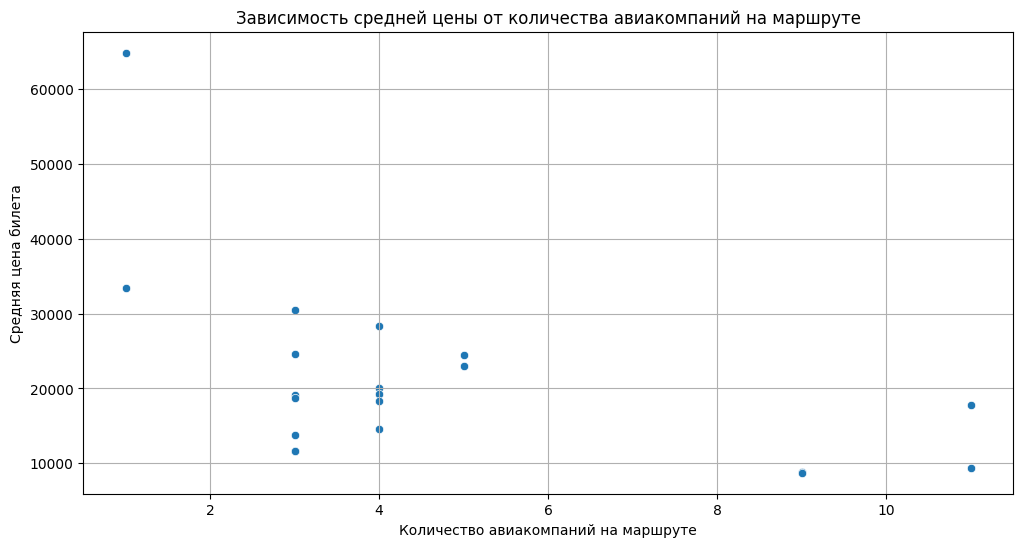

-0.5291523228551738

In [46]:
companies_per_route = df.groupby('Направление')['Авиакомпания'].nunique().reset_index().rename(columns={'Авиакомпания': 'Количество_авиакомпаний'})

average_metrics_per_route = df.groupby('Направление').agg({
    'Цена': 'mean',
    'Ручная_кладь': 'mean',
    'Багаж': 'mean',
    'Обмен': 'mean',
    'Возврат': 'mean'
}).reset_index().rename(columns={'Цена': 'Средняя_цена'})


route_competition_analysis = pd.merge(companies_per_route, average_metrics_per_route, on='Направление')


plt.figure(figsize=(12, 6))
sns.scatterplot(data=route_competition_analysis, x='Количество_авиакомпаний', y='Средняя_цена')
plt.title('Зависимость средней цены от количества авиакомпаний на маршруте')
plt.xlabel('Количество авиакомпаний на маршруте')
plt.ylabel('Средняя цена билета')
plt.grid(True)
plt.show()


correlation_price_companies = route_competition_analysis['Количество_авиакомпаний'].corr(route_competition_analysis['Средняя_цена'])
correlation_price_companies


Вывод: увеличение конкуренции приводит к снижению цен на билеты (неужели невидимая рука рынка работает?!). Однако здесь есть вероятность того, что больше компаний работают на небольших маршрутах (например, Москва - Санкт-Петербург), где цены будут при прочих равных сильно ниже, чем на более дальних перевозках, поэтому этот вопрос требует дополнительного исследования.

#### Анализ зависимости предоставляемых услуг в зависимости от конкуренции на маршруте

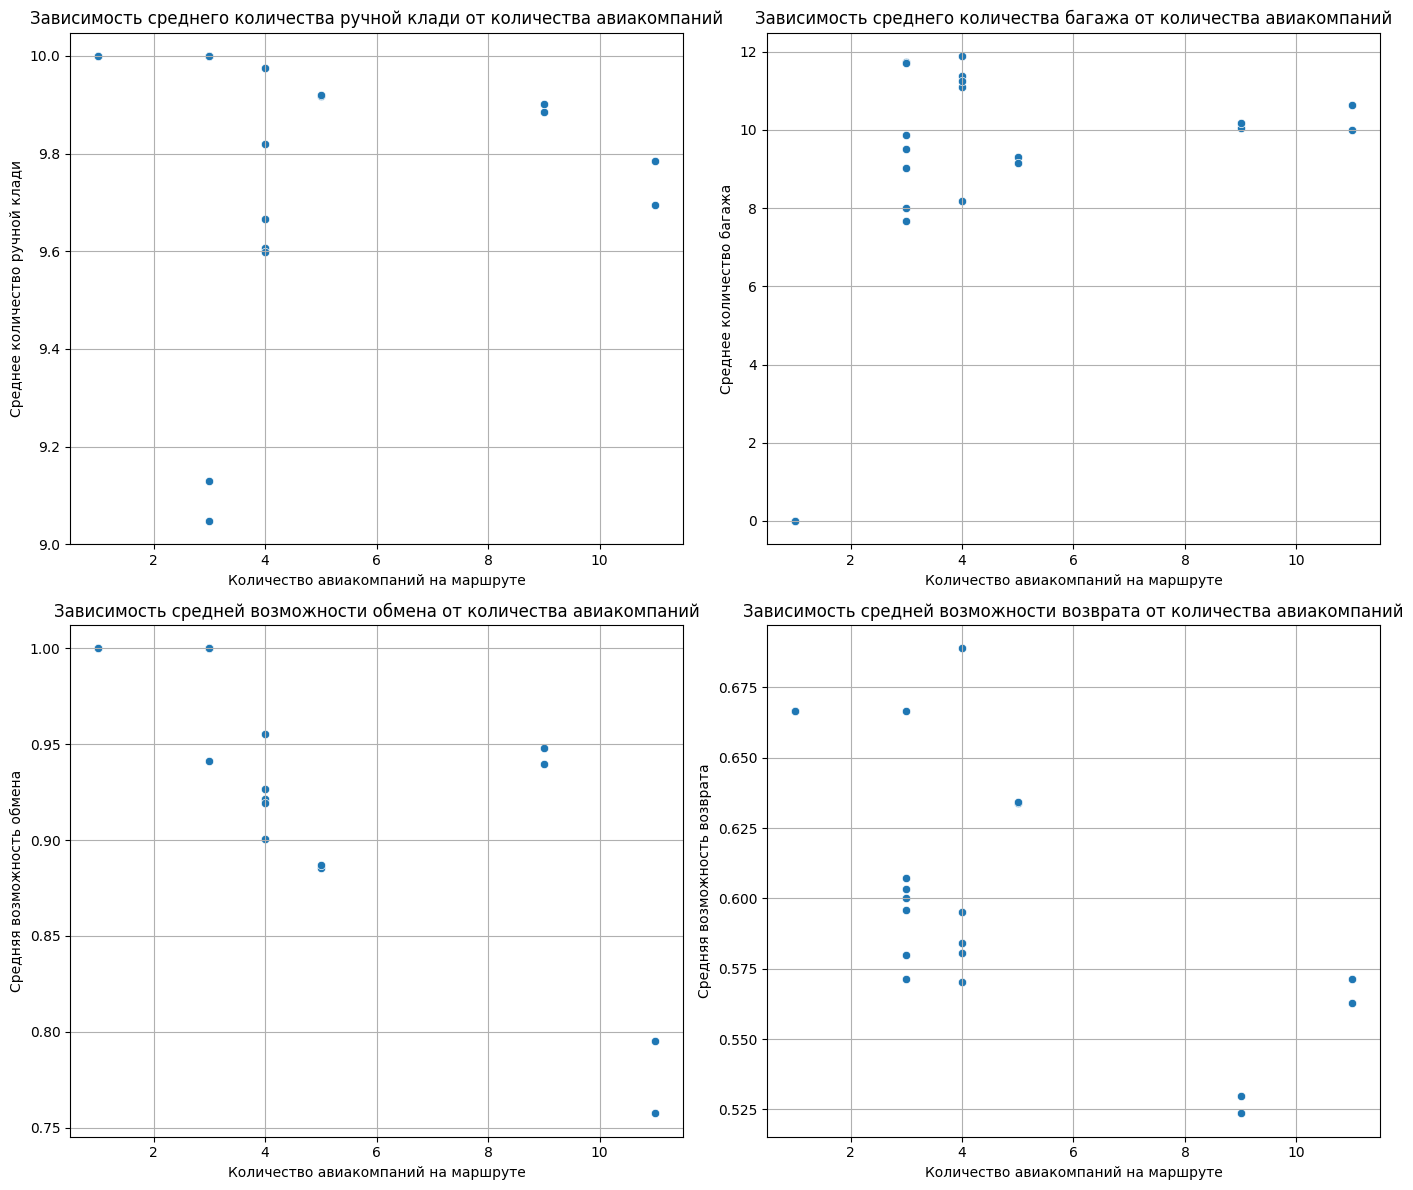

Ручная_кладь   -0.027411
Багаж           0.421959
Обмен          -0.784757
Возврат        -0.613556
Name: Количество_авиакомпаний, dtype: float64

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Ручная кладь
sns.scatterplot(data=route_competition_analysis, x='Количество_авиакомпаний', y='Ручная_кладь', ax=axs[0, 0])
axs[0, 0].set_title('Зависимость среднего количества ручной клади от количества авиакомпаний')
axs[0, 0].set_xlabel('Количество авиакомпаний на маршруте')
axs[0, 0].set_ylabel('Среднее количество ручной клади')
axs[0, 0].grid(True)

# Багаж
sns.scatterplot(data=route_competition_analysis, x='Количество_авиакомпаний', y='Багаж', ax=axs[0, 1])
axs[0, 1].set_title('Зависимость среднего количества багажа от количества авиакомпаний')
axs[0, 1].set_xlabel('Количество авиакомпаний на маршруте')
axs[0, 1].set_ylabel('Среднее количество багажа')
axs[0, 1].grid(True)

# Обмен
sns.scatterplot(data=route_competition_analysis, x='Количество_авиакомпаний', y='Обмен', ax=axs[1, 0])
axs[1, 0].set_title('Зависимость средней возможности обмена от количества авиакомпаний')
axs[1, 0].set_xlabel('Количество авиакомпаний на маршруте')
axs[1, 0].set_ylabel('Средняя возможность обмена')
axs[1, 0].grid(True)

# Возврат
sns.scatterplot(data=route_competition_analysis, x='Количество_авиакомпаний', y='Возврат', ax=axs[1, 1])
axs[1, 1].set_title('Зависимость средней возможности возврата от количества авиакомпаний')
axs[1, 1].set_xlabel('Количество авиакомпаний на маршруте')
axs[1, 1].set_ylabel('Средняя возможность возврата')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

correlations_services = route_competition_analysis[['Количество_авиакомпаний', 'Ручная_кладь', 'Багаж', 'Обмен', 'Возврат']].corr()['Количество_авиакомпаний'].drop('Количество_авиакомпаний')
correlations_services


Вывод: как ни странно, повышение конкуренции (прокси для конкурентности рынка - количество компаний на маршруте) не ведет к улучшению условий перевозки.

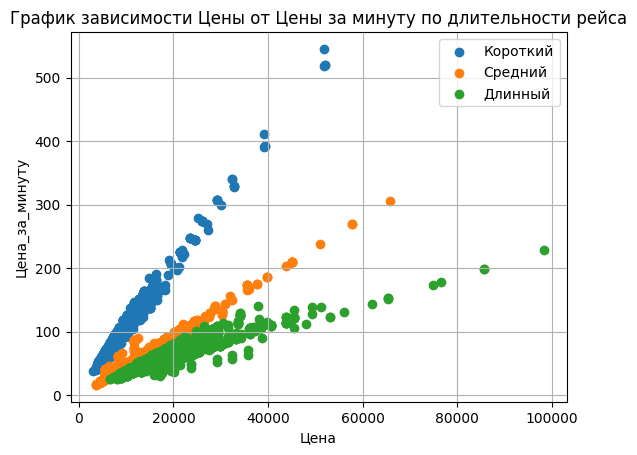

In [48]:
df['Длительность_рейса'] = pd.cut(df['Время_в_пути'], bins=[0, 120, 240, max(df['Время_в_пути'])], labels=['Короткий', 'Средний', 'Длинный'])

for time_type, group in df.groupby('Длительность_рейса'):
    plt.scatter(group["Цена"], group['Цена_за_минуту'], label=time_type)

plt.xlabel("Цена")
plt.ylabel('Цена_за_минуту')
plt.title("График зависимости Цены от Цены за минуту по длительности рейса")
plt.legend()
plt.grid(True)
plt.show()

#### Вывод

Ценообразование в расчете на минуту сильно зависит от того, насколько длительным является маршрут. Чем меньше время в пути, тем дороже обходится для пассажира минута на борту. Это связано с наличием постоянных издержек (значительные топливные издержки на взлет-посадку, персонал, обслуживание рейса, комиссии аэропортов и т.п.).

### Построение модели линейной регрессии цены авиабилета

In [49]:
# Выбор переменных
features = ['Время_в_пути', 'День_недели_отправления', 'Авиакомпания', 'Самолет', 'Багаж', 'Обмен', 'Возврат', 'Ручная_кладь']
target = 'Цена'

# Подготовка данных: кодирование категориальных переменных и разделение данных
X = df[features]
y = df[target]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обработка категориальных переменных
categorical_features = ['День_недели_отправления', 'Авиакомпания', 'Самолет']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Создание трансформера колонок
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

regressor = LinearRegression()
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])

# Обучение модели
model = pipeline.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = pipeline.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(21259586.047118634, 0.706019095813269)

In [59]:
regressor.coef_

array([ -123.92561921,  -503.19627516,  -772.85557436,  -708.01413134,
         403.90175692,   938.47574761,   765.61409555,  9862.85665599,
         417.98468396,  1728.30270139,   163.80132221,    61.43406751,
       -8501.18115351, -1859.13782478, -1867.08585855,  2125.14947517,
        -633.38490251, -1788.92834852, -2450.17714057,    66.50865234,
        2673.85766987,  -283.43200801,  1924.31624441,  3258.74547462,
         -44.99060422,  -169.05832743, -2834.26112775, -2588.79988468,
         997.54207465, -1047.15643658,  1359.12489161,  1666.2722887 ,
       -2119.5732511 ,  -579.10496884,   460.37563461,    50.95377597,
         103.34959254, -1294.36932455,  3956.38239376,   112.36371562])

In [60]:
regressor.intercept_

-701.1589289418425